# UNIQLO & Bayesian Additive Regression Trees
UNIQLO is a global Japanese clothing retailer known for its high-quality, affordable basics designed for everyday life. As of current writing, UNIQLO's parent company has experienced a mixed stock price performance. Despite it's performance, it has seen strong growth over the past year, with a notable 43% annual gian driven by solid earnings.

This jupyter book will analyze the performance of UNIQLO's stock over the course of 5 years, and will use Bayesian Additive Regression Trees to predict the closing price of UNIQLO's stock, as well as using Bayesian Regression Models.

**Note:** all values with regards to the stock prices are to be assumed the japanese currency yen.

## 1 | Importing Necessary Libraries
The cell below shows the necessary imports of several Python libraries that are commonly used for statistical modeling and data visualization. Here is a short description of each of them as follows:
- **ArviZ (az):** A library for exploratory analysis of Bayesian models.
- **Matplotlib (plt):** A plotting library for creating static, animated, and interactive visualizations in Python.
- **NumPy (np):** A library for numerical computing, providing support for arrays and mathematical functions.
- **Pandas (pd):** A data manipulation library that offers data structures for efficiently storing and analyzing data.
- **PyMC (pm):** A library for probabilistic programming that allows users to build Bayesian models.
- **PyMC-BART (pmb):** An extension for PyMC that implements Bayesian Additive Regression Trees (BART).
- **PyTensor (pt):** A library for symbolic computation used for defining and evaluating mathematical expressions.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb
import pytensor.tensor as pt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## 2 | Visual Styling & Color Cycling
The cell below is used to establish and configure a visual style for the plots created using Matplotlib and sets up a color cycle for the axes. Here are some documentation links that you can refer for future use:
- **For plt.rc():** https://jakevdp.github.io/PythonDataScienceHandbook/04.11-settings-and-stylesheets.html 
- **For ArviZ:** https://python.arviz.org/en/stable/getting_started/Introduction.html#arviz-style-sheets

In [2]:
# used to find out what styles are available
print(az.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'arviz-bluish', 'arviz-brownish', 'arviz-colors', 'arviz-cyanish', 'arviz-darkgrid', 'arviz-doc', 'arviz-docgrid', 'arviz-grayscale', 'arviz-greenish', 'arviz-orangish', 'arviz-plasmish', 'arviz-purplish', 'arviz-redish', 'arviz-royish', 'arviz-viridish', 'arviz-white', 'arviz-whitegrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [3]:
# using the grayscale style for the UNQILO plots
az.style.use("arviz-grayscale")

# importing the cycler class
from cycler import cycler

# creating a custom color cycle to be applied to all plots 
custom_cycler = cycler(color=["#000000", "#6A6A6A", "#BEBEBE", "#2A2EEC"])

# setting the default color cycle for the axes as well as the default resolution
plt.rc("axes", prop_cycle=custom_cycler)
plt.rc("figure", dpi=500)

# random seed for ensuring reproducibility
np.random.seed(123)

## 3 | Data Handling & Preprocessing
Next up, we perform data preprocessing, where we convert any form of categorical data in columns into numerical data, so that we can use a Bayesian Regression Model on it to perform analysis on the dataset.

### Converting Categorial Data into Numerical Data
We start off with converting any categorical data into numerical data. Here, we can see that the Date column of the DataFrame is categorical, so we convert them into numerical by using a reference date and subtracting any dates after that to produce a column that displays days since the reference date.

In [4]:
# check the data type of the date column
uniqlo_df = pd.read_csv("uniqlo.csv")
print(uniqlo_df["Date"].dtype)

object


In [5]:
# change the data type of the date column to datetime
uniqlo_df["Date"] = pd.to_datetime(uniqlo_df["Date"])
print(uniqlo_df["Date"].dtype)

datetime64[ns]


In [6]:
# a reference date to find the difference from
reference_date = pd.Timestamp("2012-01-04")

# update the date column to convert it into numerical data
uniqlo_df["Date"] = (uniqlo_df["Date"] - reference_date).dt.days

# renaming the date column to days since column
uniqlo_df.rename(columns={"Date" : "Days since 2012-01-04"}, inplace=True)

# view the updated dataframe
uniqlo_df

,Days since 2012-01-04,Open,High,Low,Close,Volume,Stock Trading
0,1822,42120,42330,41700,41830,610000,25628028000
1,1821,43000,43220,42540,42660,448400,19188227000
2,1820,43940,43970,43270,43270,339900,14780670000
3,1819,43140,43700,43140,43620,400100,17427993000
4,1818,43310,43660,43090,43340,358200,15547803000
...,...,...,...,...,...,...,...
1221,7,14360,14750,14280,14590,1043400,15191988000
1222,6,13890,14390,13860,14390,952300,13533413000
1223,2,13990,14030,13790,13850,765500,10635609000
1224,1,13720,13840,13600,13800,511500,7030811000


### Creating Target Variables & Feature Variables
Next up, we set which features of the dataset we want to set as the target variable and which one we want to set as the feature variables. Since we're concerned with predicting the closing price of the stock:
- **Target Variable:** `Close`
- **Feature Variables:** `Open`, `High`, `Low`

In [7]:
# the target variable
Y = uniqlo_df["Close"]

# new dataframe using feature variables
X = uniqlo_df[["Open", "High", "Low"]]

## 4 | Bayesian Regression Model
The cell below runs a Bayesian Regression Model using PyMC and Bayesian Additive Regression Trees (BART) to analyze the stock market performance of the UNIQLO's parent company's stock.

### Code Explanation
This cell below works by learning from past data on closing stock price for each day and allows for making educated guesses about new closing prices. It captures the relationships in the data between the target variables and the feature variables.

In [8]:
# creating a probabilistic model context using PyMC
with pm.Model() as model_pen:
    σ = pm.HalfNormal("σ", 1)
    μ = pmb.BART("μ", X, Y, m=50)
    y = pm.Normal("y", mu=μ, sigma=σ, observed=Y)

    # sampling process to estimate parameters of the model based on observed data
    idata_pen = pm.sample(random_seed=123)

    # generates new data based on model's learned parameters to see how well it can predict new observations
    pm.sample_posterior_predictive(idata_pen, extend_inferencedata=True, random_seed=123)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 124 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [y]


In [9]:
print(idata_pen.observed_data["y"].values)

[41830. 42660. 43270. ... 13850. 13800. 13720.]


In [10]:
# retrieving the smallest predicted value of the outcome based on the built model
idata_pen.posterior_predictive.min()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    y        float64 9.878e+03

## 5 | Plotting the Model
The cell below is used to create a plot of the posterior predictive checks (PPC). PPC is important because it helps with assessing how well the Bayesian Model fits the observed data. If the PPC don't align well with the observed data, this indicates that the model isn't adequately capturing relationships in the data.

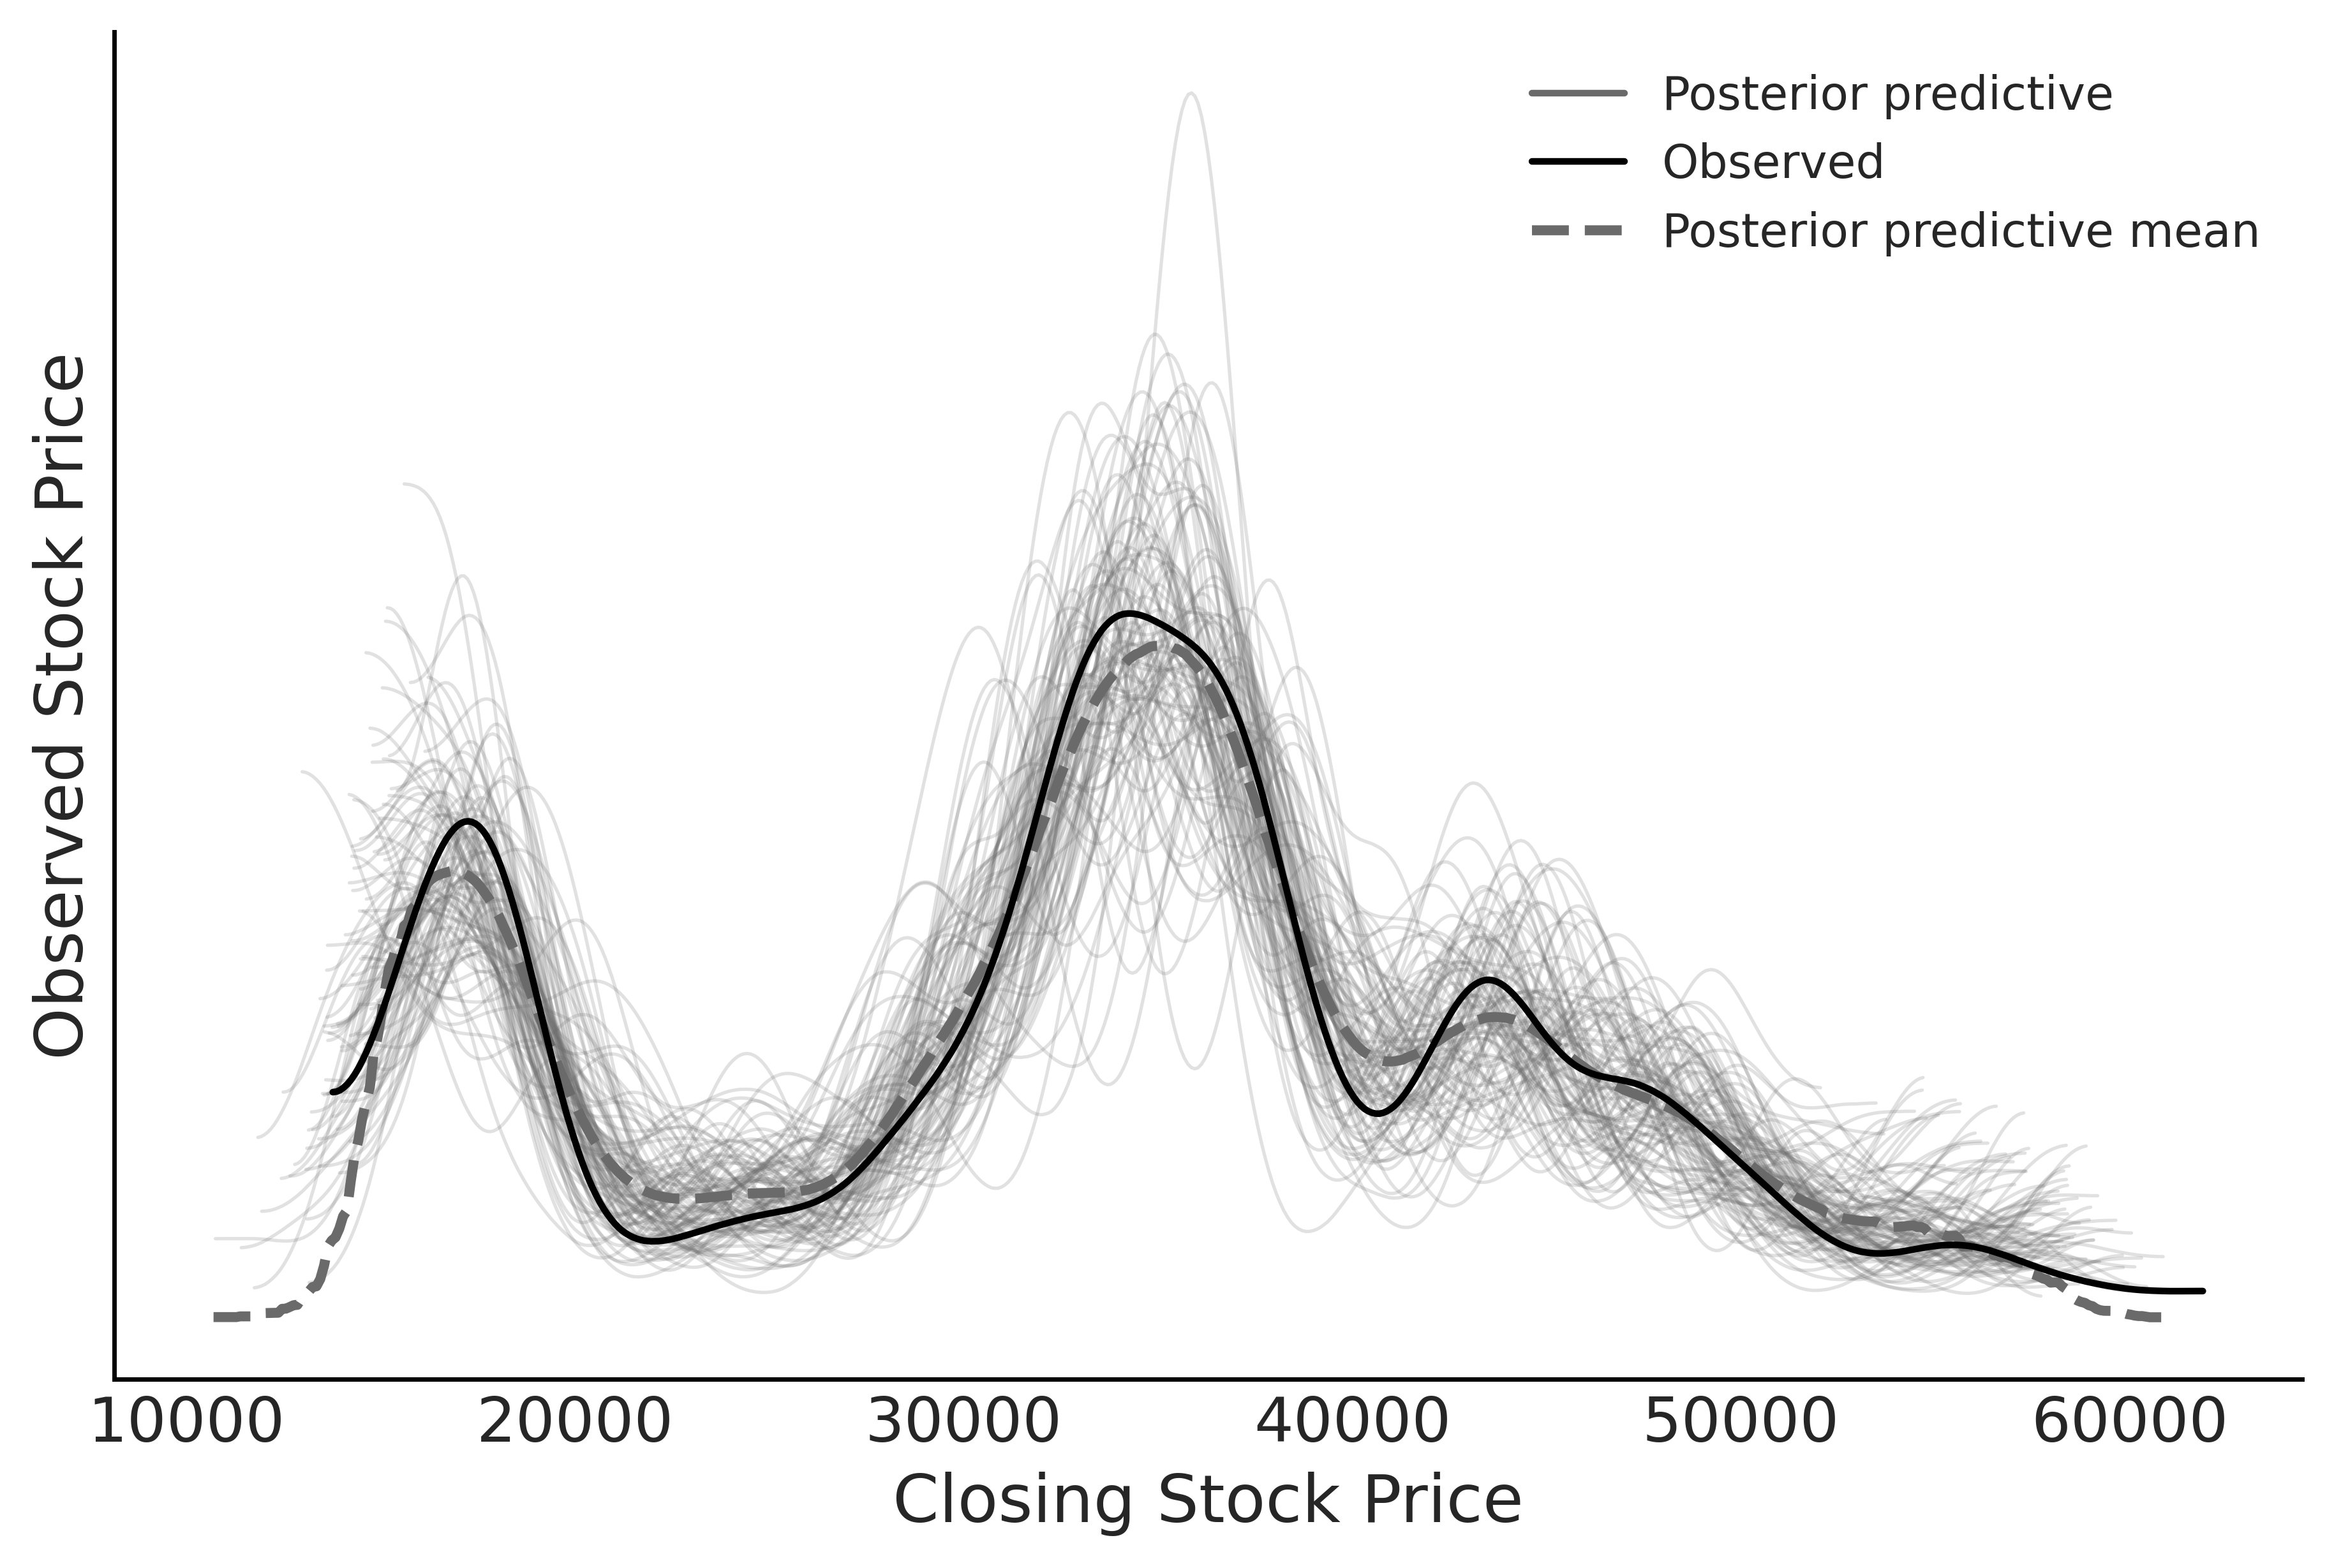

In [11]:
# creating the plot of the posterior predictive checks (PPC)
ax = az.plot_ppc(idata_pen, num_pp_samples=100, colors=["C1", "C0", "C1"])

# setting the x-label and saving the figure
ax.set_xlabel("Closing Stock Price")
ax.set_ylabel("Observed Stock Price")
plt.savefig("close_ppc.png")

## 6 | Partial Dependence Plots
The cell below creates a visual representation of how each input feature affects the closing stock price based on the BART model. Each subplot in the figure corresponds to each input feature, which shows the expected changes in the predicted outcome as that feature varies.

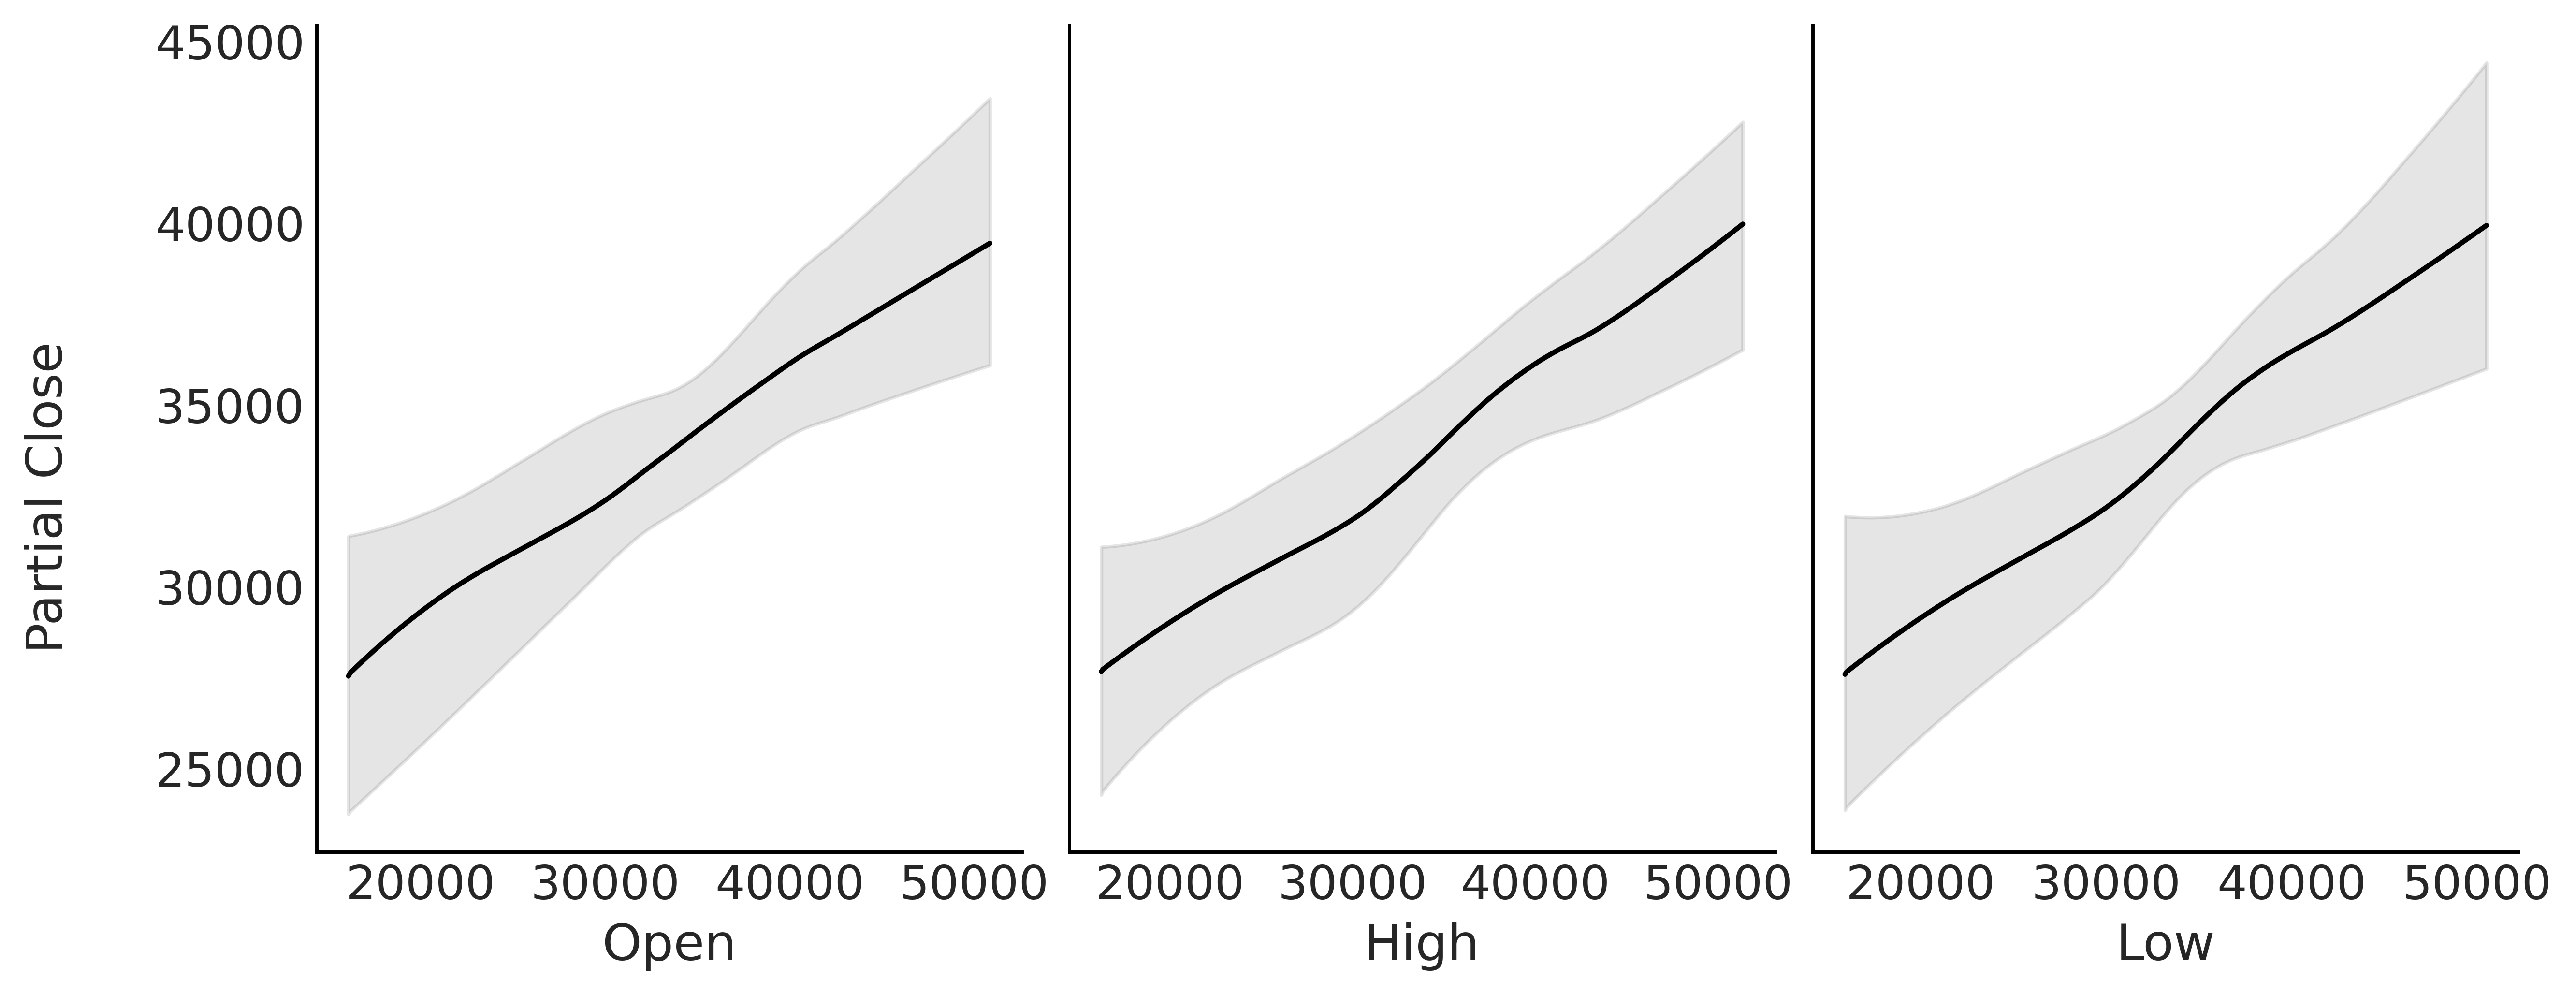

In [12]:
pmb.plot_pdp(μ, X, Y, grid=(1, 3), figsize=(10, 4))
plt.savefig("close_pdp.png", bbox_inches="tight")

## 7 | Individual Conditional Expectation (ICE) Plot
The cell below generates a Individual Conditional Expectation (ICE) plot using the `pymc_bart` library. We create a series of ICE plots that show individual predictions from the BART model change as we vary one feature while keeping the other fixed. Each line in the plots represent the prediction for a specific observation as the feature of interest changes.

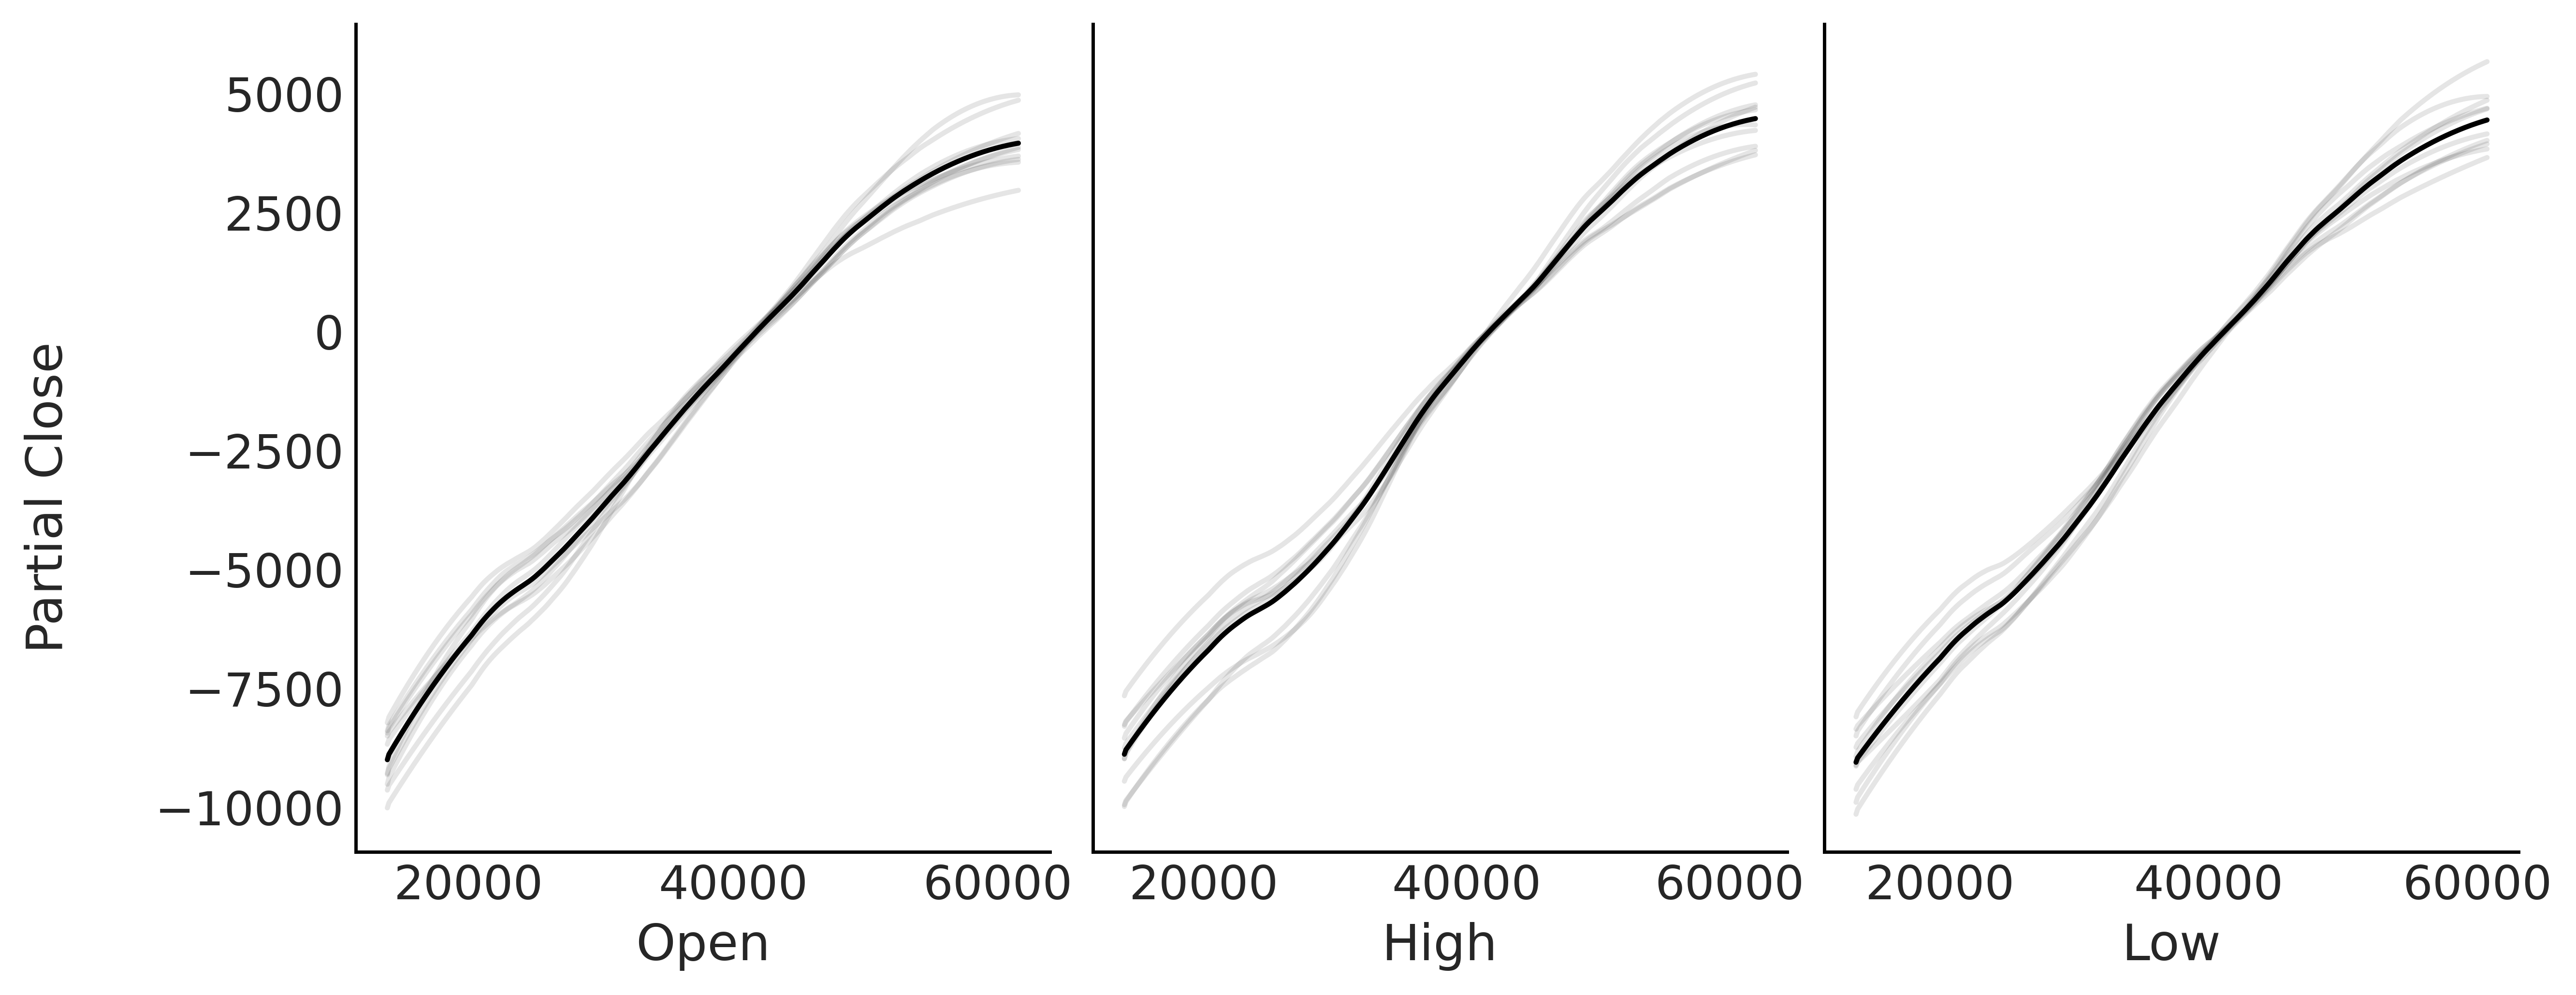

In [13]:
pmb.plot_ice(μ, X, Y, grid=(1, 3), figsize=(10, 4))
plt.savefig("close_ice.png", bbox_inches="tight")

## 8 | Variable Importance
The cell below generates and saves a plot of variable importance for the Bayesian Additive Regression Trees (BART) model. The plots visually shows the relative importance of each input feature in predicting the target variable (close stock price) based on the BART model.

/usr/local/lib/python3.11/site-packages/pymc_bart/utils.py:786: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  chains_hdi = az.hdi((var_imp_chains.T / var_imp_chains.sum(axis=1)).T)[indices]


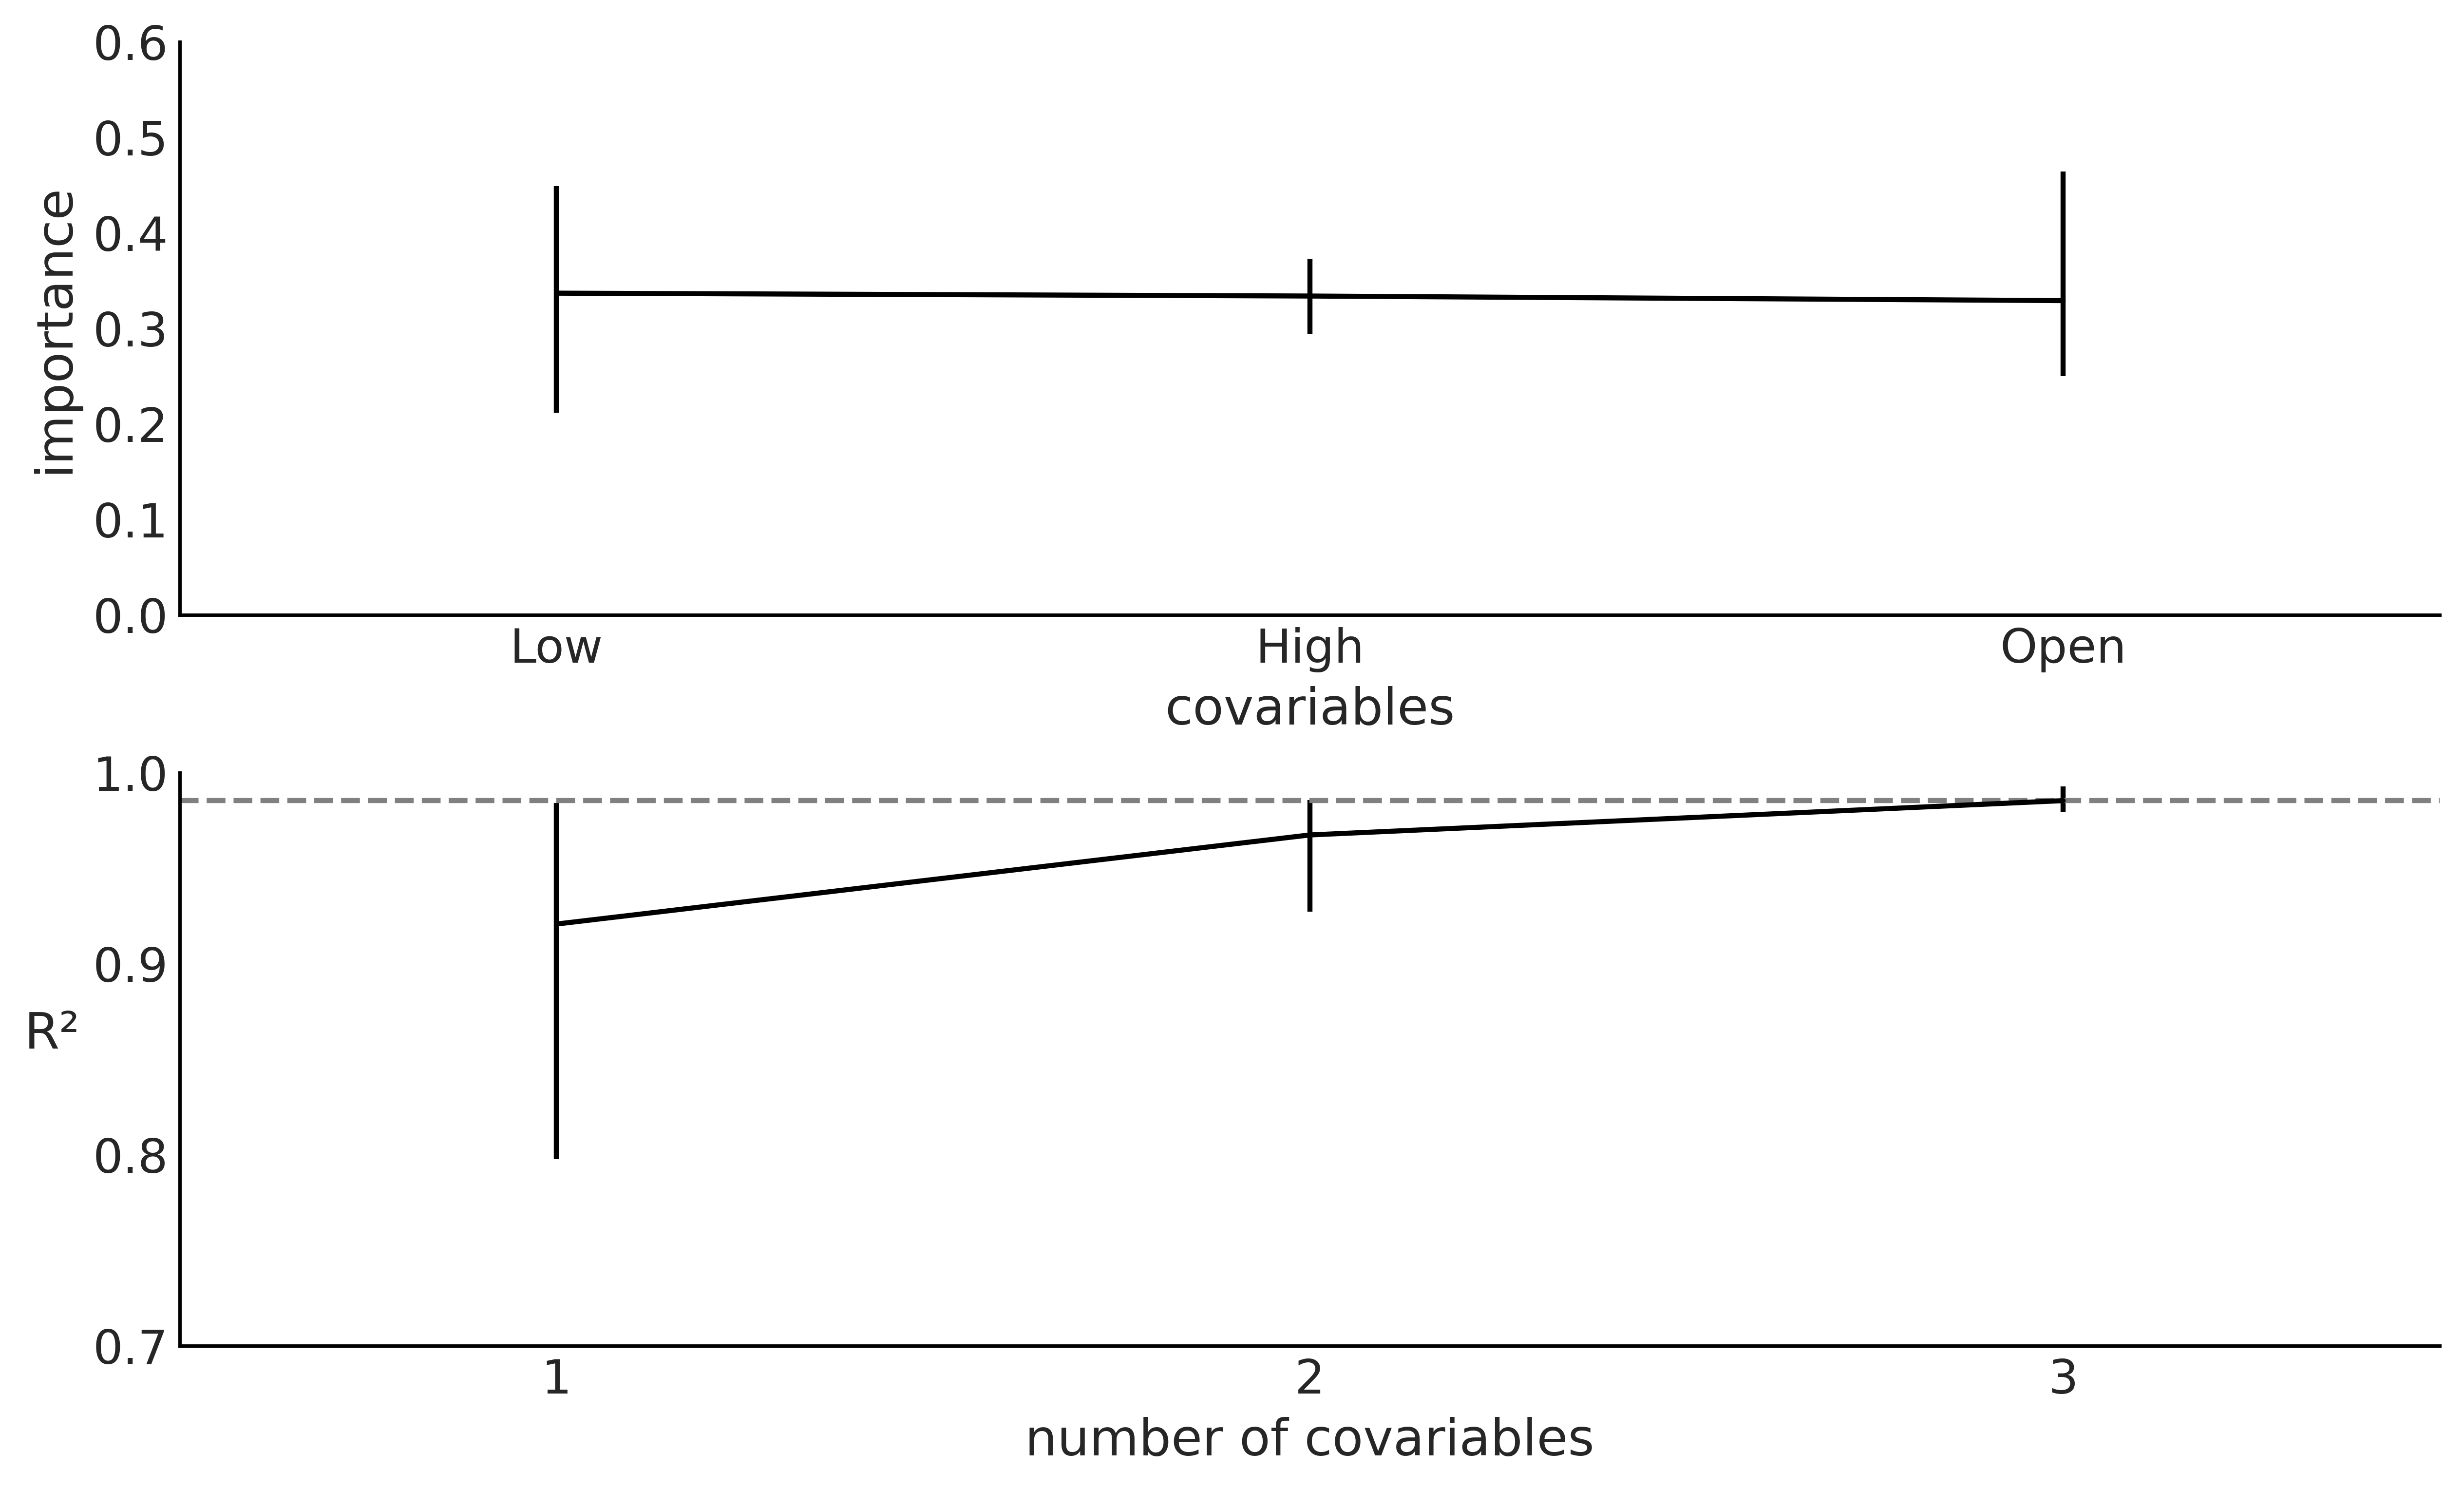

In [14]:
# used to plot the variable importance of each feature in the model
_, axes = pmb.plot_variable_importance(idata_pen, μ, X, figsize=(10, 6))

# sets the y-axis range
axes[0].set_ylim(0, .6)   # first subplot
axes[1].set_ylim(0.7, 1)  # second subplot

# saving diagram as a figure
plt.savefig("close_VI.png")

## 9 | Convergence Diagnostic Plot
The cell below generates and saves a converge diagnostic plot for the BART model. The code will produce a plot that helps you visually check if sampling chains for the μ have reached a stable distribution. A converged chain is important because it indicates that the model has explored posterior distribution, and the results are reliable.

**Note:** the y-axis is name of the BART variable to plot

### Effective Sample Size (ESS) vs R-hat (Gelman-Rubin Statistic)
**ESS:** measures the number of effectively independent samples in the chain. Due to MCMC samples being correlated, ESS is often smaller than the total number of samples. Larger the ESS, more reliable the estimate because it suggests the parameter has been explored

**R-hat:** a diagnostic metric that measures the convergence of MCMC chains. Compares the variance within each chain to the variance between multiple chains to check if they're sampling from the same distribution. Values below 1.01 are a sign of strong convergence.

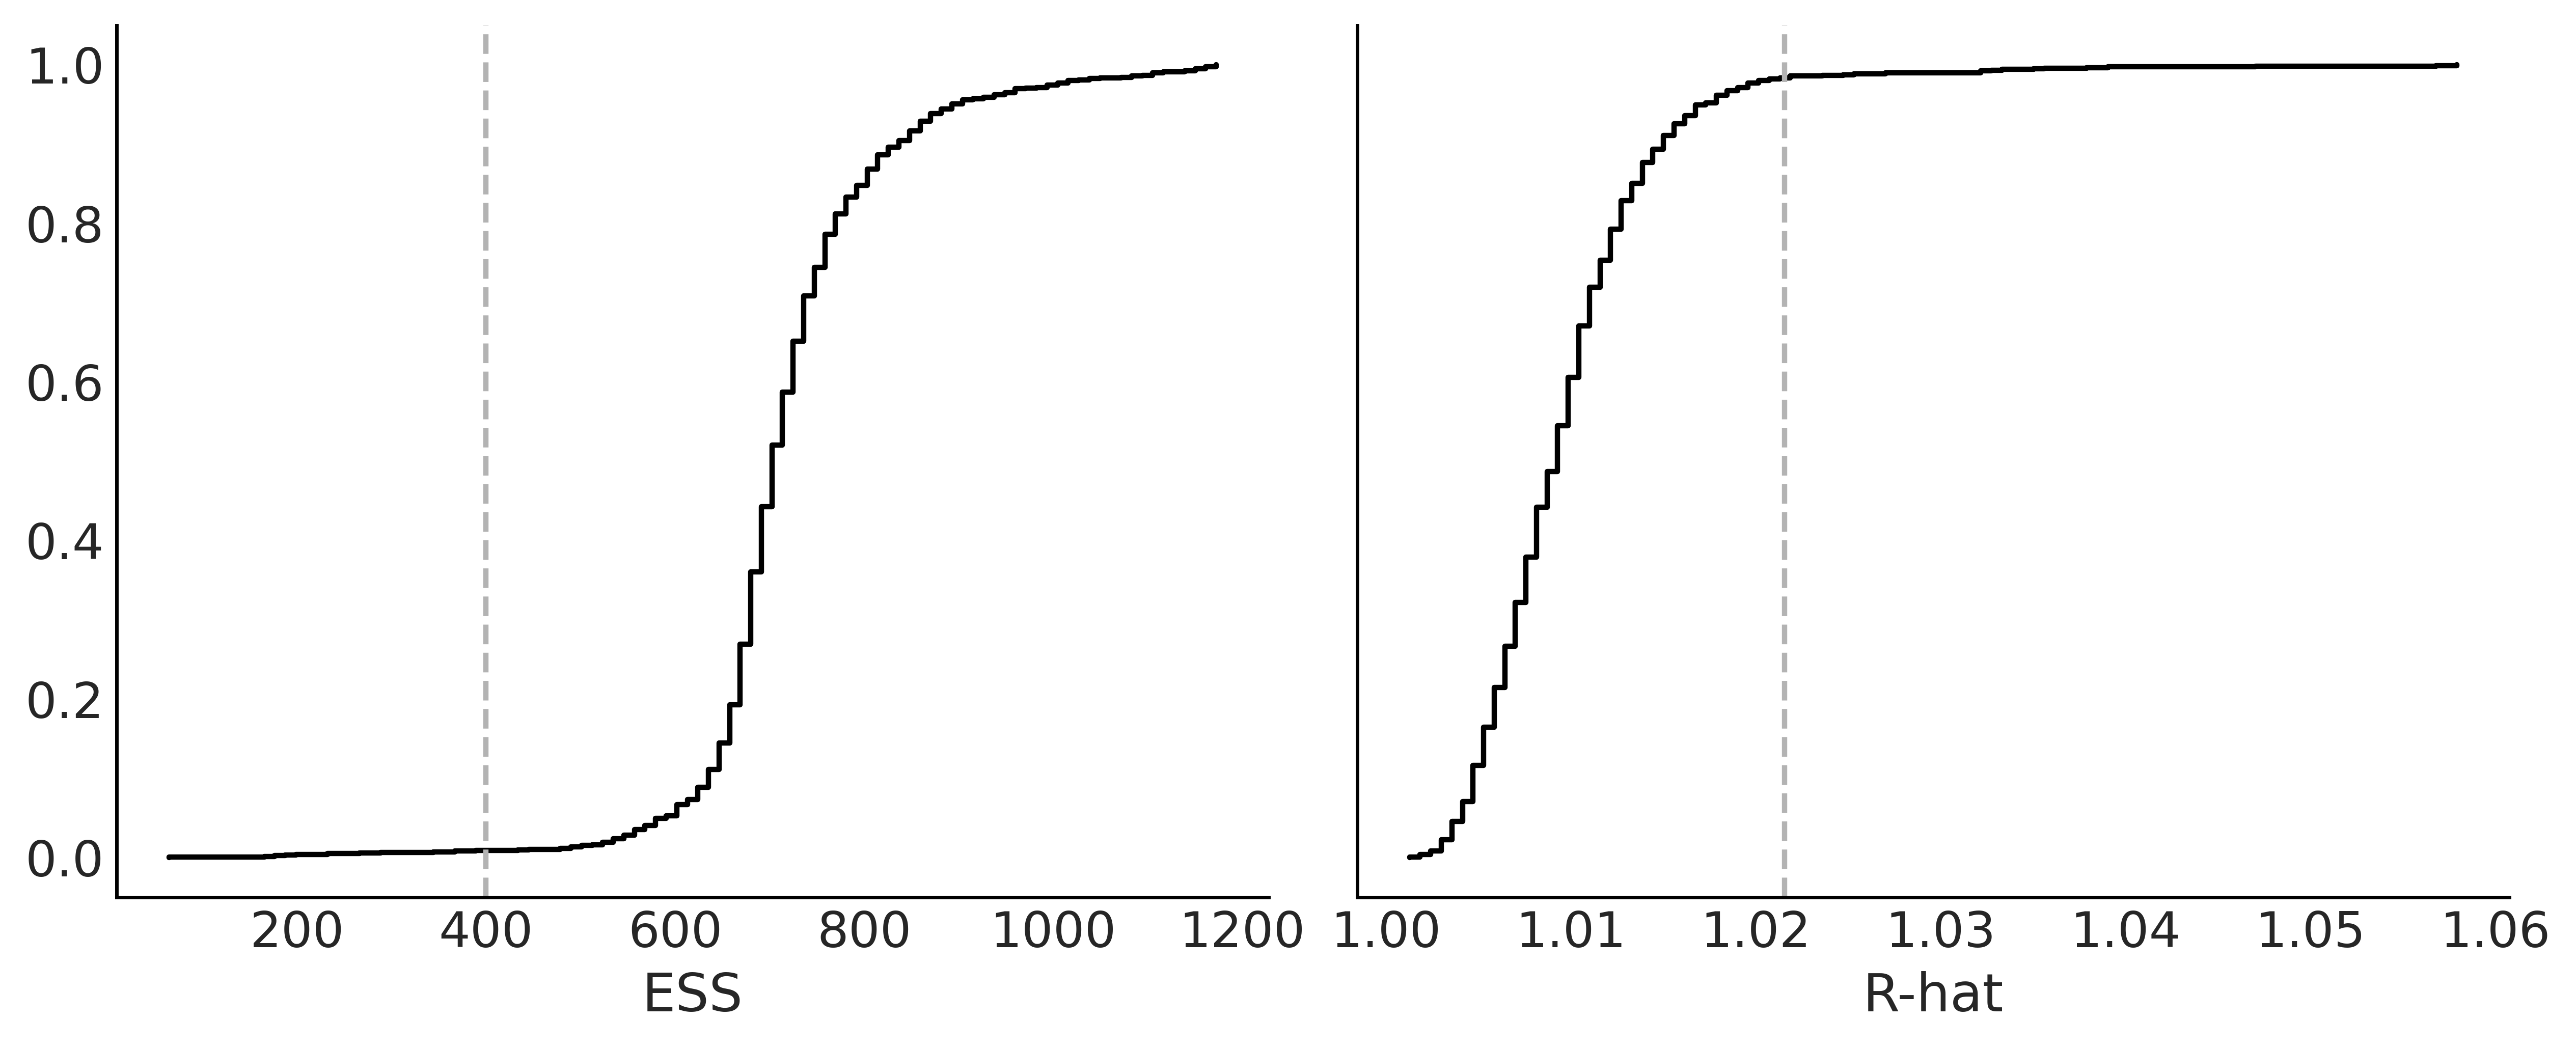

In [15]:
# used to plot the converge diagnostic plot using idata_pen
pmb.plot_convergence(idata_pen, var_name="μ", figsize=(10, 4))

# saves the figure
plt.savefig("close_convergence.png")